# Space Environment Pathways
This Jupyter Notebook will allow users to play around with the scenarios, in order to get to know the laucnh data.

If you would like to use the scen_properties of a pickle file, then this must be located under the first pyssem folder. In the same folder as model.py

In [19]:
import pandas as pd

path = '/Users/indigobrownhall/Code/pyssem/pyssem/utils/launch/data/ref_scen_SEP2.csv' # your path to the scenario csv file
T = pd.read_csv(path)

# Only use if required, you can run the model, it will save a pickle file and then you can use this to get the scenario data. 
# import pickle
# with open('../scenario-properties-baseline.pkl', 'rb') as f:
#     scen_properties = pickle.load(f)

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_29281/3087786101.py:4: DtypeWarning: Columns (4,5,63) have mixed types. Specify dtype option on import or set low_memory=False.
  T = pd.read_csv(path)


Show all of the columns available, the data types and an example:

In [18]:
# print each column name, the data type and an example
for col in T.columns:
    print(f"Column: {col}")
    print(f"Data Type: {T[col].dtype}")
    print(f"Example: {T[col].iloc[0]}")
    print()

Column: obj_id
Data Type: int64
Example: 1

Column: phase_desc
Data Type: object
Example: debris/derelict

Column: phase
Data Type: float64
Example: 4.0

Column: par_id
Data Type: float64
Example: nan

Column: operating_agency
Data Type: object
Example: nan

Column: const_name
Data Type: object
Example: nan

Column: const_shell_id
Data Type: float64
Example: nan

Column: mass
Data Type: float64
Example: 1.47

Column: area
Data Type: float64
Example: 0.0214

Column: diam_lcola
Data Type: float64
Example: 0.165068

Column: diam_tumbl
Data Type: float64
Example: 0.131711

Column: diam_char
Data Type: float64
Example: 0.146674

Column: obj_type
Data Type: int64
Example: 2

Column: length
Data Type: float64
Example: nan

Column: width
Data Type: float64
Example: nan

Column: depth
Data Type: float64
Example: nan

Column: active
Data Type: float64
Example: 0.0

Column: maneuverable
Data Type: float64
Example: 0.0

Column: stkp_flg
Data Type: float64
Example: 0.0

Column: stkp_box_r
Data Type

<Axes: >

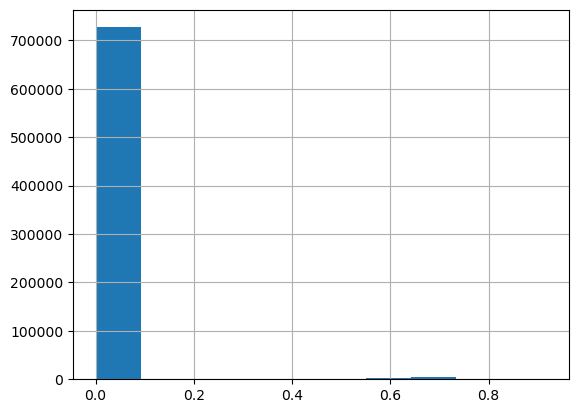

In [3]:
T['ecc'].hist()

### Use this code - as a template -  to be able to explore the data. 

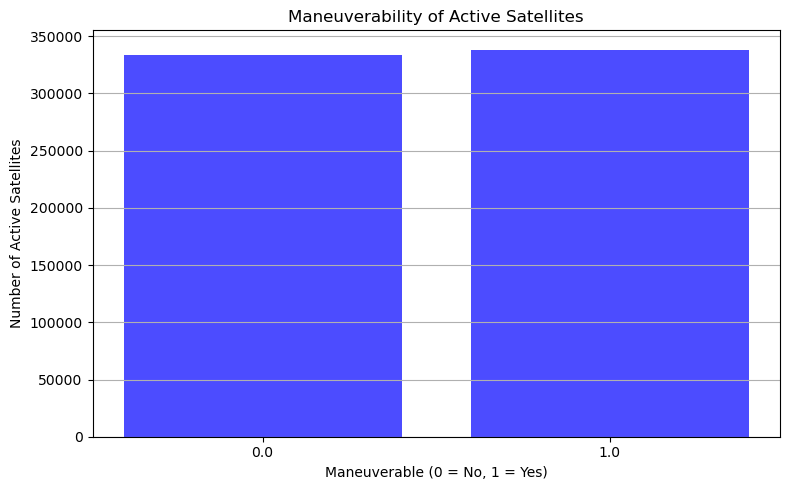

In [4]:
import matplotlib.pyplot as plt

# Filter active satellites
active_satellites = T[T['obj_type'] == 2]

# Get counts of maneuverability values
maneuver_counts = active_satellites['maneuverable'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(maneuver_counts.index.astype(str), maneuver_counts.values, color='blue', alpha=0.7)
plt.xlabel('Maneuverable (0 = No, 1 = Yes)')
plt.ylabel('Number of Active Satellites')
plt.title('Maneuverability of Active Satellites')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Now we can check which filters work. 

In [5]:
# This function has been taken for pyssem and allows you to pass a list of species queries and test it. 

def assign_species_to_population(T, species_mapping):
    """
    Applies a list of pandas query strings to assign species classes to the population.
    
    :param T: pandas.DataFrame representing the population
    :param species_mapping: list of assignment strings (e.g., T.loc[...] = ...)
    :return: updated DataFrame with 'species_class' assigned
    """
    # Initialize the column
    T['species_class'] = "Unknown"

    # Apply each mapping rule via exec
    for rule in species_mapping:
        try:
            exec(rule)
        except Exception as e:
            print(f"Error applying rule: {rule}\n\t{e}")

    # Print summary of resulting species_class assignments
    print("\nSpecies class distribution:")
    print(T['species_class'].value_counts())

    # Remove all objects that are still unknown
    try:
        
        T = T[T['species_class'] != "Unknown"]
        print(f"\n{T['species_class'].value_counts()['Unknown']} objects/rows are being removed.")
    except KeyError:
        print("No unknown species classes found.")

    return T

In [6]:
species_configuration = [
    "T.loc[(T['obj_type'] == 2) & (T['phase'] == 2) & (T['maneuverable'] == 1), 'species_class'] = 'Su'",
    "T.loc[(T['obj_type'] == 2) & (T['mass'] <= 20), 'species_class'] = 'Sns'",
    "T.loc[(T['obj_type'] == 2) & (T['phase'] == 2) & (T['maneuverable'] == 1) & T['const_name'].notna(), 'species_class'] = 'S'",
    "T.loc[(T['obj_type'] >= 3), 'species_class'] = 'N'",
    "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'"
]

# # filter between 200 and 2000
T['apogee'] = T['sma'] * (1 + T['ecc'])
T['perigee'] = T['sma'] * (1 - T['ecc'])
T['alt'] = (T['apogee'] + T['perigee']) / 2 - 6378.1

T = T[T['alt'] <= 2000]
T = T[T['alt'] >= 200]
# T = T[T['year_start'] <= 2025]

T_new = assign_species_to_population(T, species_configuration)

print(T_new['species_class'].value_counts())



Species class distribution:
species_class
Unknown    304616
S          288279
Sns         54410
N           50995
Su          21168
B            6034
Name: count, dtype: int64
No unknown species classes found.
species_class
S      288279
Sns     54410
N       50995
Su      21168
B        6034
Name: count, dtype: int64


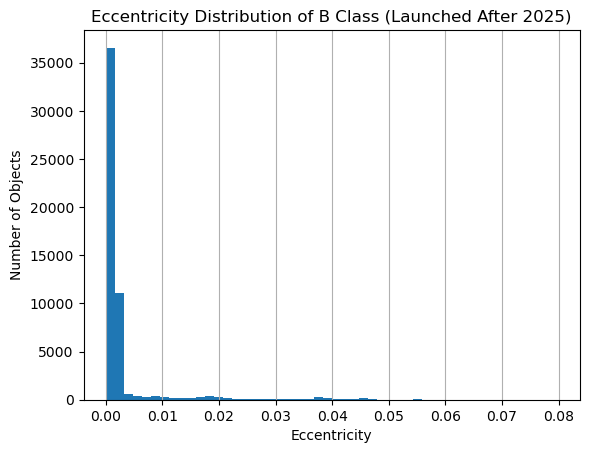

In [7]:
import matplotlib.pyplot as plt

# Filter to B-class objects with year_start > 2025
T_b = T_new[(T_new['species_class'] == 'Sns') & (T_new['year_start'] > 2025)]

# Plot histogram of eccentricity
T_b['ecc'].hist(bins=50)
plt.xlabel('Eccentricity')
plt.ylabel('Number of Objects')
plt.title('Eccentricity Distribution of B Class (Launched After 2025)')
plt.grid(axis='y')
plt.show()

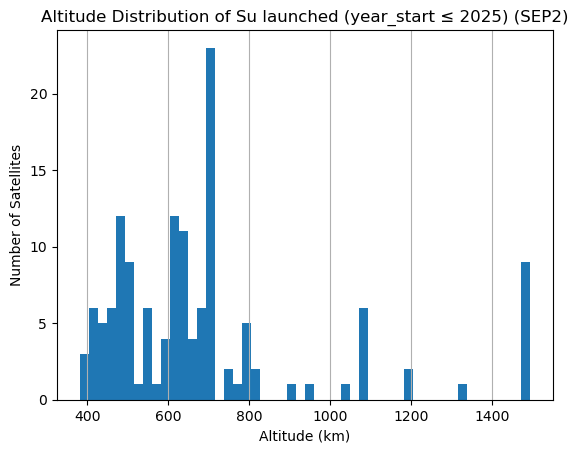

In [8]:
T_su = T_new[(T_new['species_class'] == 'Su') & (T_new['year_start'] <= 2026)]
T_su['alt'].hist(bins=50)
plt.xlabel('Altitude (km)')
plt.ylabel('Number of Satellites')
plt.title('Altitude Distribution of Su launched (year_start ≤ 2025) (SEP2)')
plt.grid(axis='y')
plt.show()

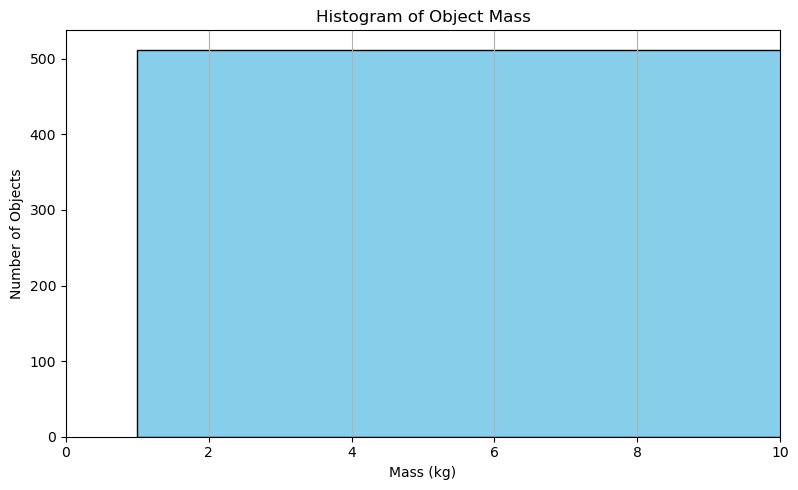

In [9]:
import matplotlib.pyplot as plt

debris = T[T['obj_type'] >= 3]
debris = debris[debris['mass'] >= 1]

plt.figure(figsize=(8, 5))
debris['mass'].hist(bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Mass (kg)')
plt.ylabel('Number of Objects')
plt.title('Histogram of Object Mass')
plt.grid(axis='y')
plt.tight_layout()
plt.xlim(0,10)
plt.show()

In [10]:
import matplotlib.pyplot as plt

# Drop rows with missing year_start, mass, or phase
scatter_data = N_only[['year_start', 'mass', 'phase']].dropna()

print(scatter_data['phase'].value_counts())

# Create scatter plot, color by 'phase'
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    scatter_data['year_start'],
    scatter_data['mass'],
    c=scatter_data['phase'],
    cmap='viridis',  # or 'tab10', 'plasma', etc.
    alpha=0.7,
    s=20
)

plt.title('Mass vs. Start Year for N Species (Colored by Phase)')
plt.xlabel('Start Year')
plt.ylabel('Mass (kg)')
plt.ylim(0, 10)
plt.grid(True)
plt.colorbar(scatter, label='Phase')
plt.tight_layout()
plt.show()

NameError: name 'N_only' is not defined

In [ ]:
T_new

In [ ]:
# load the results.json data
import json
import os
import matplotlib.pyplot as plt

# Define the path to the JSON file
json_file_path = '/Users/indigobrownhall/Code/pyssem/figures/SEP2/results.json'

# Check if the file exists
if not os.path.exists(json_file_path):
    raise FileNotFoundError(f"The file {json_file_path} does not exist.")

# Load the JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Extract time and launch entries
times = data['times']
launch_entries = data['launch']

# Plot each species' launch counts
plt.figure(figsize=(12, 6))

for entry in launch_entries:
    species = entry['species']
    counts = entry['counts']
    plt.plot(times, counts, label=species)

plt.title('Cumulative Launches Over Time by Species')
plt.xlabel('Time')
plt.ylabel('Cumulative Launches')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Modelling for AMOS VnV

In [15]:
T_new.head()

,obj_id,phase_desc,phase,par_id,operating_agency,const_name,const_shell_id,mass,area,diam_lcola,...,eci_y,eci_z,eci_vx,eci_vy,eci_vz,obj_id_str,species_class,apogee,perigee,alt
1,2,debris/derelict,4.0,NaN,NaN,NaN,NaN,9.8,0.2027,0.508021,...,-7026.596629,4.076188,6.469328,-1.633299,4.293850,2,Sns,9291.666217,6930.143783,1732.805
2,3,debris/derelict,4.0,NaN,NaN,NaN,NaN,31.0,0.8834,1.060556,...,-4532.774331,4.322777,2.854645,-5.668931,4.048007,3,B,9682.124597,6932.617403,1929.271
8,9,debris/derelict,4.0,NaN,NaN,NaN,NaN,19.0,0.2043,0.510022,...,1182.107488,12.672456,-0.636013,2.881411,6.839570,9,Sns,7235.434280,6958.635720,718.935
9,10,debris/derelict,4.0,NaN,NaN,NaN,NaN,450.0,6.0461,2.774551,...,2227.394535,12.524375,-1.077763,-2.801240,6.950219,10,B,7288.615854,6960.752146,746.584
10,11,debris/derelict,4.0,NaN,NaN,NaN,NaN,24.0,0.6249,0.891991,...,-4669.865131,8.023678,2.909009,-3.867094,5.230435,11,B,8059.854741,7880.273259,1591.964


In [16]:
import pandas as pd
import numpy as np

# Assume T_new is already loaded as a DataFrame

# 1. Filter to only Sns species_class
sns_df = T_new[T_new['species_class'] == 'Sns']

# 2. Define 50 km bins from 300 to 1000 km
bin_edges = np.arange(300, 1001, 50)
bin_labels = [f"{b}-{b+50}" for b in bin_edges[:-1]]

# 3. Add a bin column based on altitude
sns_df = sns_df.copy()
sns_df['alt_bin'] = pd.cut(sns_df['alt'], bins=bin_edges, labels=bin_labels, right=False)

# 4. For each bin, select the first object (or you can use .sample(1) for random)
selected = sns_df.groupby('alt_bin').head(1)

# 5. Drop the 'alt_bin' column for output (optional)
selected = selected.drop(columns=['alt_bin'])

# 6. Export to CSV
selected.to_csv("Sns_50km_bins.csv", index=False)

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_29281/1455388214.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  selected = sns_df.groupby('alt_bin').head(1)
